# Sentiment with Deep Neural Networks

## Overview

- Build/design a model using layers
- Train a model using a training loop
- Use a binary cross-entropy loss function
- Compute the accuracy of the model
- Predict using a custom imput

We will use Google's Trax to build our deep networks:
- Trax source code can be found on Github: [Trax](https://github.com/google/trax)
- The Trax code also uses the JAX library: [JAX](https://jax.readthedocs.io/en/latest/index.html)

## Import libraries

In [3]:
# pip install trax 

In [1]:
import os 
import random as rnd

import trax

#trax.supervised.trainer_lib.init_random_number_generators(31)

# import trax.fastmath.numpy
import trax.fastmath.numpy as np

# import trax.layers
from trax import layers as tl

from utils import Layer, load_tweets, process_tweet

INFO:tensorflow:tokens_length=568 inputs_length=512 targets_length=114 noise_density=0.15 mean_noise_span_length=3.0 


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/amanprasad/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amanprasad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing the Data

In [2]:
import numpy as np

# Load positive and negative tweets
all_positive_tweets, all_negative_tweets = load_tweets()

# View the total number of positive and negative tweets.
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

# Split positive set into validation and training
val_pos   = all_positive_tweets[4000:] # generating validation set for positive tweets
train_pos  = all_positive_tweets[:4000]# generating training set for positive tweets

# Split negative set into validation and training
val_neg   = all_negative_tweets[4000:] # generating validation set for negative tweets
train_neg  = all_negative_tweets[:4000] # generating training set for nagative tweets

# Combine training data into one set
train_x = train_pos + train_neg 

# Combine validation data into one set
val_x  = val_pos + val_neg

# Set the labels for the training set (1 for positive, 0 for negative)
train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))

# Set the labels for the validation set (1 for positive, 0 for negative)
val_y  = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))

print(f"length of train_x {len(train_x)}")
print(f"length of val_x {len(val_x)}")

The number of positive tweets: 5000
The number of negative tweets: 5000
length of train_x 8000
length of val_x 2000


## Building the vocabulary

Now build the vocabulary.
- Map each word in each tweet to an integer (an "index"). 
- Note that we will build the vocabulary based on the training data. 
- To do so, you will assign an index to everyword by iterating over your training set.

The vocabulary will also include some special tokens
- `__PAD__`: padding
- `</e>`: end of line
- `__UNK__`: a token representing any word that is not in the vocabulary.

In [19]:
Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2} 

# Note that we build vocab using training data
for tweet in train_x: 
    processed_tweet = process_tweet(tweet)
    for word in processed_tweet:
        if word not in Vocab: 
            Vocab[word] = len(Vocab)
    
print("Total words in vocab are",len(Vocab))

i=0
for key in Vocab.keys():
    if i<=10:
        print(str(key) + '->' + str(Vocab[key]))
        i+=1
    else:
        break

Total words in vocab are 9092
__PAD__->0
__</e>__->1
__UNK__->2
followfriday->3
top->4
engag->5
member->6
commun->7
week->8
:)->9
hey->10



## Converting a tweet to a tensor

Below is a function that will convert each tweet to a tensor (a list of unique integer IDs representing the processed tweet).
- For words in the tweet that are not in the vocabulary, set them to the unique ID for the token `__UNK__`.

##### Example
Input a tweet:
```CPP
'@happypuppy, is Maria happy?'
```

The tweet_to_tensor will first convert the tweet into a list of tokens (including only relevant words)
```CPP
['maria', 'happi']
```

Then it will convert each word into its unique integer

```CPP
[2, 56]
```

In [20]:
def tweet_to_tensor(tweet, vocab_dict, unk_token='__UNK__', verbose=False):
    '''
    Input: 
        tweet - A string containing a tweet
        vocab_dict - The words dictionary
        unk_token - The special string for unknown tokens
        verbose - Print info durign runtime
    Output:
        tensor_l - A python list with
        
    '''  
    
    # Process the tweet into a list of words
    # where only important words are kept (stop words removed)
    word_l = process_tweet(tweet)
    
    if verbose:
        print("List of words from the processed tweet:")
        print(word_l)
        
    # Initialize the list that will contain the unique integer IDs of each word
    tensor_l = []
    
    # Get the unique integer ID of the __UNK__ token
    unk_ID = vocab_dict[unk_token]
    
    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")
        
    # for each word in the list:
    for word in word_l:
        
        # Get the unique integer ID.
        # If the word doesn't exist in the vocab dictionary,
        # use the unique ID for __UNK__ instead.
        if word in vocab_dict.keys():
            word_ID = vocab_dict[word]
        else:
            word_ID = unk_ID
        
        # Append the unique integer ID to the tensor list.
        tensor_l.append(word_ID) 
    
    return tensor_l

In [21]:
print("Actual tweet is\n", val_pos[0])
print("\nTensor of tweet:\n", tweet_to_tensor(val_pos[0], vocab_dict=Vocab))

Actual tweet is
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan

Tensor of tweet:
 [1065, 136, 479, 2351, 745, 8146, 1123, 745, 53, 2, 2672, 791, 2, 2, 349, 601, 2, 3489, 1017, 597, 4559, 9, 1065, 157, 2, 2]


## Creating a batch generator

We use batches when training our data sets. 
- If instead of training with batches of examples, we were to train a model with one example at a time, it would take a very long time to train the model. 
- We will now build a data generator that takes in the positive/negative tweets and returns a batch of training examples. It returns the model inputs, the targets (positive or negative labels) and the weight for each target

In [22]:
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    '''
    Input: 
        data_pos - Set of posstive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - An array specifying the importance of each example
        
    '''     
    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples
    assert batch_size % 2 == 0
    
    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2
    
    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
    
    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))
    
    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)
        
    stop = False
    
    # Loop indefinitely
    while not stop:  
        
        # create a batch with positive and negative examples
        batch = []
        
        # First part: Pack n_to_take positive examples
        
        # Start from pos_index and increment i up to n_to_take
        for i in range(n_to_take):
                    
            # If the positive index goes past the positive dataset lenght,
            if pos_index >= len_data_pos: 
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                
                # If user wants to keep re-using the data, reset the index
                pos_index = 0
                
                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)
                    
            # get the tweet as pos_index
            tweet = data_pos[pos_index_lines[pos_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment pos_index by one
            pos_index = pos_index + 1


        # Second part: Pack n_to_take negative examples
    
        # Using the same batch list, start from neg_index and increment i up to n_to_take
        for i in range(n_to_take):
            
            # If the negative index goes past the negative dataset length,
            if neg_index >= len_data_neg:
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                    
                # If user wants to keep re-using the data, reset the index
                neg_index = 0
                
                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)
            # get the tweet as neg_index
            tweet = data_neg[neg_index_lines[neg_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment neg_index by one
            neg_index = neg_index + 1


        if stop:
            break;

        # Update the start index for positive data 
        # so that it's n_to_take positions after the current pos_index
        pos_index += n_to_take
        
        # Update the start index for negative data 
        # so that it's n_to_take positions after the current neg_index
        neg_index += n_to_take
        
        # Get the max tweet length (the length of the longest tweet) 
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch]) 
        
        
        # Initialize the input_l, which will 
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:

            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len - len(tensor)
            
            # Generate a list of zeros, with length n_pad
            pad_l = [0]*n_pad
            
            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor + pad_l
            
            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.array(tensor_pad_l)
  
        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos = [1]*n_to_take
        
        # Generate the list of targets for the negative examples (a list of zeros)
        # The length is the number of negative examples in the batch
        target_neg = [0]*n_to_take
        
        # Concatenate the positve and negative targets
        target_l = target_pos + target_neg
        
        # Convert the target list into a numpy array
        targets = np.array(target_l)

        # Example weights: Treat all examples equally importantly.
        example_weights = np.ones_like(targets)
        
        yield inputs, targets, example_weights

We will create a third data generator that does not loop, for testing the final accuracy of the model.

In [23]:
# Set the random number generator for the shuffle procedure
rnd.seed(30) 

# Create the training data generator
def train_generator(batch_size, shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, True, Vocab, shuffle)

# Create the validation data generator
def val_generator(batch_size, shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, True, Vocab, shuffle)

# Create the validation data generator
def test_generator(batch_size, shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, False, Vocab, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[2005 4451 3201    9    0    0    0    0    0    0    0]
 [4954  567 2000 1454 5174 3499  141 3499  130  459    9]
 [3761  109  136  583 2930 3969    0    0    0    0    0]
 [ 250 3761    0    0    0    0    0    0    0    0    0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [24]:
# Test the train_generator

# Create a data generator for training data,
# which produces batches of size 4 (for tensors and their respective targets)
tmp_data_gen = train_generator(batch_size = 4)

# Call the data generator to get one batch and its targets
tmp_inputs, tmp_targets, tmp_example_weights = next(tmp_data_gen)

print(f"The inputs shape is {tmp_inputs.shape}")
print(f"The targets shape is {tmp_targets.shape}")
print(f"The example weights shape is {tmp_example_weights.shape}")

for i,t in enumerate(tmp_inputs):
    print(f"input tensor: {t}; target {tmp_targets[i]}; example weights {tmp_example_weights[i]}")

The inputs shape is (4, 14)
The targets shape is (4,)
The example weights shape is (4,)
input tensor: [3 4 5 6 7 8 9 0 0 0 0 0 0 0]; target 1; example weights 1
input tensor: [10 11 12 13 14 15 16 17 18 19 20  9 21 22]; target 1; example weights 1
input tensor: [5738 2901 3761    0    0    0    0    0    0    0    0    0    0    0]; target 0; example weights 1
input tensor: [ 858  256 3652 5739  307 4458  567 1230 2767  328 1202 3761    0    0]; target 0; example weights 1


## Model

Now we will implement a classifier using neural networks. Here is the model architecture we will be implementing. 

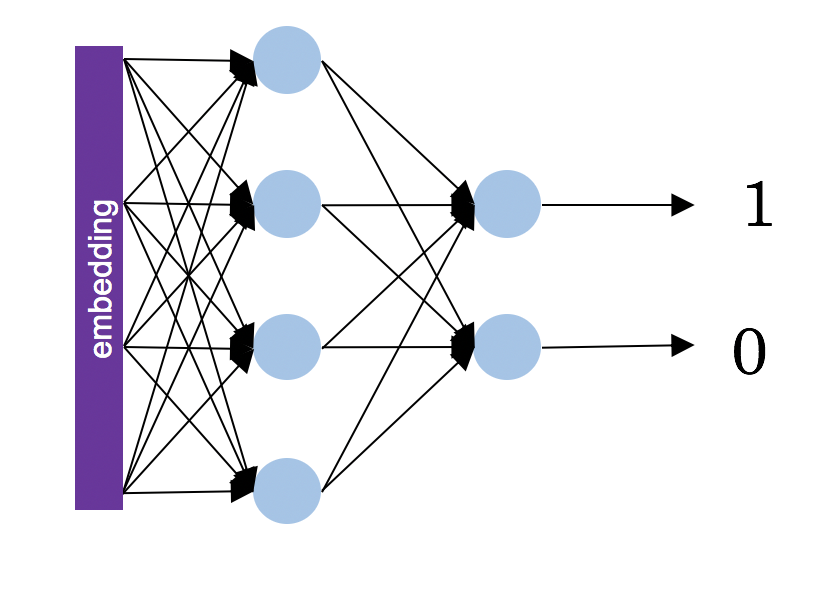

In [26]:
from IPython.display import Image
Image(filename='/Users/amanprasad/Documents/Courses_IIT_Fall_2019/NLP/Deep_Learning_Sentiment_Analysis/nn.jpg')

For the model implementation, we will use the Trax layers library `tl`.

**Online documentation**

- [tl.Dense](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Dense)

- [tl.Serial](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#module-trax.layers.combinators)

- [tl.Embedding](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Embedding)

- [tl.Mean](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.Mean)

- [tl.LogSoftmax](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.core.LogSoftmax)

Implement the classifier function.

In [27]:
def classifier(vocab_size=len(Vocab), embedding_dim=256, output_dim=2, mode='train'):
        
    # create embedding layer
    embed_layer = tl.Embedding(
        vocab_size=vocab_size, # Size of the vocabulary
        d_feature=embedding_dim)  # Embedding dimension
    
    # Create a mean layer, to create an "average" word embedding
    mean_layer = tl.Mean(axis=1)
    
    # Create a dense layer, one unit for each output
    dense_output_layer = tl.Dense(n_units = output_dim)

    
    # Create the log softmax layer (no parameters needed)
    log_softmax_layer = tl.LogSoftmax()
    
    # Use tl.Serial to combine all layers
    # and create the classifier
    # of type trax.layers.combinators.Serial
    model = tl.Serial(
      embed_layer, 
      mean_layer, 
      dense_output_layer,  
      log_softmax_layer 
    )    
    
    return model

In [28]:
tmp_model = classifier()

In [29]:
print(type(tmp_model))
display(tmp_model)

<class 'trax.layers.combinators.Serial'>


Serial[
  Embedding_9092_256
  Mean
  Dense_2
  LogSoftmax
]

# Training

To train a model on a task, Trax defines an abstraction [`trax.supervised.training.TrainTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.TrainTask) which packages the train data, loss and optimizer (among other things) together into an object.

Similarly to evaluate a model, Trax defines an abstraction [`trax.supervised.training.EvalTask`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.EvalTask) which packages the eval data and metrics (among other things) into another object.

The final piece tying things together is the [`trax.supervised.training.Loop`](https://trax-ml.readthedocs.io/en/latest/trax.supervised.html#trax.supervised.training.Loop) abstraction that is a very simple and flexible way to put everything together and train the model, all the while evaluating it and saving checkpoints.
Using `Loop` will save a lot of code compared to always writing the training loop by hand.

## Training the model

Now we train your model. 

Let's define the `TrainTask`, `EvalTask` and `Loop` in preparation to train the model.

In [30]:
from trax.supervised import training

batch_size = 16
rnd.seed(271)

train_task = training.TrainTask(
    labeled_data=train_generator(batch_size=batch_size, shuffle=True),
    loss_layer=tl.CrossEntropyLoss(),
    optimizer=trax.optimizers.Adam(0.01),
    n_steps_per_checkpoint=10,
)

eval_task = training.EvalTask(
    labeled_data=val_generator(batch_size=batch_size, shuffle=True),
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
)

model = classifier()

/Users/amanprasad/opt/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [31]:
output_dir = '~/model/'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

/Users/amanprasad/model/


This defines a model trained using [`tl.CrossEntropyLoss`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.CrossEntropyLoss) optimized with the [`trax.optimizers.Adam`](https://trax-ml.readthedocs.io/en/latest/trax.optimizers.html#trax.optimizers.adam.Adam) optimizer, all the while tracking the accuracy using [`tl.Accuracy`](https://trax-ml.readthedocs.io/en/latest/trax.layers.html#trax.layers.metrics.Accuracy) metric. We also track `tl.CrossEntropyLoss` on the validation set.

In [32]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''
    training_loop = training.Loop(
                                classifier,  # The learning model
                                train_task,  # The training task
                                eval_tasks = [eval_task], # The evaluation task
                                output_dir = output_dir) # The output directory

    training_loop.run(n_steps = n_steps)

    # Return the training_loop, since it has the model.
    return training_loop

In [33]:
training_loop = train_model(model, train_task, eval_task, 100, output_dir_expand)


Step    210: Ran 10 train steps in 4.90 secs
Step    210: train CrossEntropyLoss |  0.01327003
Step    210: eval  CrossEntropyLoss |  0.00061373
Step    210: eval          Accuracy |  1.00000000

Step    220: Ran 10 train steps in 2.49 secs
Step    220: train CrossEntropyLoss |  0.01101276
Step    220: eval  CrossEntropyLoss |  0.01711916
Step    220: eval          Accuracy |  1.00000000

Step    230: Ran 10 train steps in 1.81 secs
Step    230: train CrossEntropyLoss |  0.00557242
Step    230: eval  CrossEntropyLoss |  0.00170874
Step    230: eval          Accuracy |  1.00000000

Step    240: Ran 10 train steps in 1.20 secs
Step    240: train CrossEntropyLoss |  0.03575243
Step    240: eval  CrossEntropyLoss |  0.05399340
Step    240: eval          Accuracy |  1.00000000

Step    250: Ran 10 train steps in 0.64 secs
Step    250: train CrossEntropyLoss |  0.01250257
Step    250: eval  CrossEntropyLoss |  0.04764247
Step    250: eval          Accuracy |  1.00000000

Step    260: Ran 10

In [34]:
# Create a generator object
tmp_train_generator = train_generator(16)

# get one batch
tmp_batch = next(tmp_train_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

print(f"The batch is a tuple of length {len(tmp_batch)} because position 0 contains the tweets, and position 1 contains the targets.") 
print(f"The shape of the tweet tensors is {tmp_inputs.shape} (num of examples, length of tweet tensors)")
print(f"The shape of the labels is {tmp_targets.shape}, which is the batch size.")
print(f"The shape of the example_weights is {tmp_example_weights.shape}, which is the same as inputs/targets size.")

The batch is a tuple of length 3 because position 0 contains the tweets, and position 1 contains the targets.
The shape of the tweet tensors is (16, 15) (num of examples, length of tweet tensors)
The shape of the labels is (16,), which is the batch size.
The shape of the example_weights is (16,), which is the same as inputs/targets size.


In [37]:
# feed the tweet tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)
print(f"The prediction shape is {tmp_pred.shape}, num of tensor_tweets as rows")
print("Column 0 is the probability of a negative sentiment (class 0)")
print("Column 1 is the probability of a positive sentiment (class 1)")
print()
print("View the prediction array")
tmp_pred

The prediction shape is (16, 2), num of tensor_tweets as rows
Column 0 is the probability of a negative sentiment (class 0)
Column 1 is the probability of a positive sentiment (class 1)

View the prediction array


DeviceArray([[-8.5035267e+00, -2.0265579e-04],
             [-7.5096507e+00, -5.4788589e-04],
             [-6.6772985e+00, -1.2598038e-03],
             [-6.6560555e+00, -1.2869835e-03],
             [-1.0415575e+01, -3.0040741e-05],
             [-8.0679379e+00, -3.1328201e-04],
             [-8.5725498e+00, -1.8930435e-04],
             [-2.0971968e+00, -1.3102055e-01],
             [-1.2874603e-05, -1.1260046e+01],
             [-1.4829636e-04, -8.8150167e+00],
             [-1.8119812e-05, -1.0914301e+01],
             [ 0.0000000e+00, -1.8955309e+01],
             [-4.0292740e-04, -7.8167524e+00],
             [-6.3419342e-05, -9.6680069e+00],
             [-4.5776367e-05, -9.9906464e+00],
             [-7.2479248e-05, -9.5306406e+00]], dtype=float32)

In [38]:
# turn probabilites into category predictions
tmp_is_positive = tmp_pred[:,1] > tmp_pred[:,0]
for i, p in enumerate(tmp_is_positive):
    print(f"Neg log prob {tmp_pred[i,0]:.4f}\tPos log prob {tmp_pred[i,1]:.4f}\t is positive? {p}\t actual {tmp_targets[i]}")

Neg log prob -8.5035	Pos log prob -0.0002	 is positive? True	 actual 1
Neg log prob -7.5097	Pos log prob -0.0005	 is positive? True	 actual 1
Neg log prob -6.6773	Pos log prob -0.0013	 is positive? True	 actual 1
Neg log prob -6.6561	Pos log prob -0.0013	 is positive? True	 actual 1
Neg log prob -10.4156	Pos log prob -0.0000	 is positive? True	 actual 1
Neg log prob -8.0679	Pos log prob -0.0003	 is positive? True	 actual 1
Neg log prob -8.5725	Pos log prob -0.0002	 is positive? True	 actual 1
Neg log prob -2.0972	Pos log prob -0.1310	 is positive? True	 actual 1
Neg log prob -0.0000	Pos log prob -11.2600	 is positive? False	 actual 0
Neg log prob -0.0001	Pos log prob -8.8150	 is positive? False	 actual 0
Neg log prob -0.0000	Pos log prob -10.9143	 is positive? False	 actual 0
Neg log prob 0.0000	Pos log prob -18.9553	 is positive? False	 actual 0
Neg log prob -0.0004	Pos log prob -7.8168	 is positive? False	 actual 0
Neg log prob -0.0001	Pos log prob -9.6680	 is positive? False	 actual

In [39]:
# View the array of booleans
print("Array of booleans")
display(tmp_is_positive)

# convert boolean to type int32
# True is converted to 1
# False is converted to 0
tmp_is_positive_int = tmp_is_positive.astype(np.int32)


# View the array of integers
print("Array of integers")
display(tmp_is_positive_int)

# convert boolean to type float32
tmp_is_positive_float = tmp_is_positive.astype(np.float32)

# View the array of floats
print("Array of floats")
display(tmp_is_positive_float)

Array of booleans


DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
             False, False, False, False, False, False, False, False],            dtype=bool)

Array of integers


DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Array of floats


DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
             0.], dtype=float32)

In [40]:
print(f"True == 1: {True == 1}")
print(f"True == 2: {True == 2}")
print(f"False == 0: {False == 0}")
print(f"False == 2: {False == 2}")

True == 1: True
True == 2: False
False == 0: True
False == 2: False


# Evaluation  

## Computing the accuracy on a batch

We now write a function that evaluates our model on the validation set and returns the accuracy. 
- `preds` contains the predictions.
    - Its dimensions are `(batch_size, output_dim)`.  `output_dim` is two in this case.  Column 0 contains the probability that the tweet belongs to class 0 (negative sentiment). Column 1 contains probability that it belongs to class 1 (positive sentiment).
    - If the probability in column 1 is greater than the probability in column 0, then interpret this as the model's prediction that the example has label 1 (positive sentiment).  
    - Otherwise, if the probabilities are equal or the probability in column 0 is higher, the model's prediction is 0 (negative sentiment).
- `y` contains the actual labels.
- `y_weights` contains the weights to give to predictions.

In [41]:
def compute_accuracy(preds, y, y_weights):
    """
    Input: 
        preds: a tensor of shape (dim_batch, output_dim) 
        y: a tensor of shape (dim_batch, output_dim) with the true labels
        y_weights: a n.ndarray with the a weight for each example
    Output: 
        accuracy: a float between 0-1 
        weighted_num_correct (np.float32): Sum of the weighted correct predictions
        sum_weights (np.float32): Sum of the weights
    """
    # Create an array of booleans, 
    # True if the probability of positive sentiment is greater than
    # the probability of negative sentiment
    # else False
    is_pos =  preds[:,1]>preds[:,0]

    is_pos_int = np.int32(is_pos)
    
    correct = is_pos_int == y

    # Count the sum of the weights.
    sum_weights = np.sum(y_weights)
    
    correct_float = np.float32(correct)
    
    # Multiply each prediction with its corresponding weight.
    weighted_correct_float = correct_float * y_weights

    # Sum up the weighted correct predictions (of type np.float32), to go in the
    # denominator.
    weighted_num_correct = np.sum(weighted_correct_float)
 
    # Divide the number of weighted correct predictions by the sum of the
    # weights.
    accuracy = weighted_num_correct/sum_weights

    return accuracy, weighted_num_correct, sum_weights


## Testing your model on Validation Data

Now we test our model's prediction accuracy on validation data. 

This program will take in a data generator and our model. 
- The generator allows to get batches of data. We can use it with a `for` loop:

```
for batch in iterator: 
   # do something with that batch
```

`batch` has dimensions `(X, Y, weights)`. 
- Column 0 corresponds to the tweet as a tensor (input).
- Column 1 corresponds to its target (actual label, positive or negative sentiment).
- Column 2 corresponds to the weights associated (example weights)
- We can feed the tweet into model and it will return the predictions for the batch. 


In [42]:
def test_model(generator, model):
    '''
    Input: 
        generator: an iterator instance that provides batches of inputs and targets
        model: a model instance 
    Output: 
        accuracy: float corresponding to the accuracy
    '''
    
    accuracy = 0.
    total_num_correct = 0
    total_num_pred = 0
    
    for batch in generator: 
        
        # Retrieve the inputs from the batch
        inputs = batch[0]
        
        # Retrieve the targets (actual labels) from the batch
        targets = batch[1]
        
        # Retrieve the example weight.
        example_weight = batch[2]

        # Make predictions using the inputs
        pred = model(inputs)
        
        # Calculate accuracy for the batch by comparing its predictions and targets
        batch_accuracy, batch_num_correct, batch_num_pred = compute_accuracy(pred, targets, example_weight)
        
        # Update the total number of correct predictions
        # by adding the number of correct predictions from this batch
        total_num_correct += batch_num_correct
        
        # Update the total number of predictions 
        # by adding the number of predictions made for the batch
        total_num_pred += batch_num_pred

    # Calculate accuracy over all examples
    accuracy = total_num_correct/total_num_pred
    
    return accuracy

In [43]:
# testing the accuracy of your model
model = training_loop.eval_model
accuracy = test_model(test_generator(16), model)

print(f'The accuracy of your model on the validation set is {accuracy:.4f}', )

The accuracy of your model on the validation set is 0.9931


## Testing with our own input

In [44]:
def predict(sentence):
    inputs = np.array(tweet_to_tensor(sentence, vocab_dict=Vocab))
    
    # Batch size 1, add dimension for batch, to work with the model
    inputs = inputs[None, :]  
    
    # predict with the model
    preds_probs = model(inputs)
    
    # Turn probabilities into categories
    preds = int(preds_probs[0, 1] > preds_probs[0, 0])
    
    sentiment = "negative"
    if preds == 1:
        sentiment = 'positive'

    return preds, sentiment

In [45]:
# try a positive sentence
sentence = "It's such a nice day, think i'll be taking Sid to Ramsgate fish and chips for lunch at Peter's fish factory and then the beach maybe"
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

print()
# try a negative sentence
sentence = "I hated my day, it was the worst, I'm so sad."
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

The sentiment of the sentence 
***
"It's such a nice day, think i'll be taking Sid to Ramsgate fish and chips for lunch at Peter's fish factory and then the beach maybe"
***
is positive.

The sentiment of the sentence 
***
"I hated my day, it was the worst, I'm so sad."
***
is negative.
